# AutoResearchMailer

# AutoResearchMailer: Intelligent Research + Batch Email Agent
🔍 Purpose:
Automatically search a topic, summarize it using an open-source LLM (Gemma-2b-it via Groq), and email the summary to multiple recipients loaded from a CSV file — all through a clean Flask frontend.

# 🧠 End-to-End Workflow Breakdown

🔢 Step	🔧 Task	⚙️ Tools/Libraries	💡 Description

1️⃣	Input topic from u  	-Flask, index.html	User enters a research topic in a simple web form

2️⃣	Load recipient emails	pandas, emails.csv	Reads list of email addresses from a CSV file

3️⃣	Search relevant info	WikipediaQueryRun, ArxivAPIWrapper	Pulls articles from Wikipedia & Arxiv for the topic

4️⃣	Summarize content	Groq API, gemma-2b-it model	Uses an open-source LLM to generate a short, clean summary

5️⃣	Email the summary	smtplib, email.message	Sends the summary to each email in the CSV file

6️⃣	Show results	render_template, result.html	Web UI displays the final summary and list of recipients

7️⃣	Backend reusability	LangGraph, pickle	Agent logic is saved & reused using a .pkl model in Flask

In [197]:
# #  Install required libraries
# !pip install flask pandas langchain langchain_community langchain-groq langgraph cassio wikipedia arxiv tiktoken chromadb
# # 

#  AstraDB Setup 

In [198]:
# !pip install --upgrade cassandra-driver==3.29.2

# import cassandra
# print(cassandra.__version__)



In [199]:
!pip install cassio


Defaulting to user installation because normal site-packages is not writeable


In [200]:
# import cassio
# ## connection of the ASTRA DB


# cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

# Load Groq LLM 

In [201]:
import os
from langchain_groq import ChatGroq

groq_api_key = os.environ.get("GROK_API_KEY")

# llm=ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")
llm = ChatGroq(groq_api_key=groq_api_key, model="llama3-70b-8192") 

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C8184DB830>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C81855CEF0>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

# Load External Tools (Wikipedia + Arxiv)

In [202]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=2000)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper, return_direct=True)

arxiv_wrapper = ArxivAPIWrapper()
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper, return_direct=True)

# Optional test
print(wiki_tool.run("LangChain"))
print(arxiv_tool.run("1605.08386"))


Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.
Published: 2016-05-26
Title: Heat-bath random walks with Markov bases
Authors: Caprice Stanley, Tobias Windisch
Summary: Graphs on lattice points are studied whose edges come from a finite set of
allowed moves of arbitrary length. We show that the diameter of these graphs on
fibers of a fixed integer matrix can be bounded from above by a constant. We
then study the mixing behaviour of heat-bath random walks on these graphs. We
also state explicit conditions on the set of moves so that the heat-bath random
walk, a generalization of the Glauber dynamics, is an expander in fixed
dimension.


# Summarizer + Email Sender (Multiple Emails)

# step-1   https://myaccount.google.com/u/2/security  ---- here on 2-step authentication like passkey , authenticator . google prompt , add mobile number etc

# step-2 --- https://myaccount.google.com/u/2/apppasswords   -- here enter appname then 16 digit password will be generated copy and paste here

In [203]:
import smtplib
from email.message import EmailMessage

def summarize_text(text):
    prompt = f"Summarize the following text: {text}"
    return llm.invoke(prompt)

def send_email(summary, subject="AI Summary Report", to="aryanpatel77462@gmail.com"):
    msg = EmailMessage()
    msg["Subject"] = subject
    msg["From"] = "aryan9140782212@gmail.com"
    msg["To"] = to
    msg.set_content(summary)

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
        smtp.login("aryan9140782212@gmail.com", "kgfc ylkw doax ljqh")  # App password only
        smtp.send_message(msg)

    return f"Email sent successfully to {to}"


In [204]:

# import csv

# def load_recipients(csv_path="emails.csv"):
#     with open(csv_path, newline='') as f:
#         reader = csv.DictReader(f)
#         return [row["email"] for row in reader]




# import smtplib
# from email.message import EmailMessage

# def summarize_text(text):
#     prompt = f"Summarize the following text: {text}"
#     return llm.invoke(prompt)

# def send_email(summary, subject="AI Summary Report Made by Aryan Patel", csv_path="emails.csv"):
#     recipients = load_recipients(csv_path)  # list of emails
# 
#     msg = EmailMessage()
#     msg["Subject"] = subject
#     msg["From"] = "aryan9140782212@gmail.com"
#     msg["To"] = ", ".join(recipients)  # header formatting
#     msg.set_content(summary)


#     with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
#         smtp.login("aryan9140782212@gmail.com", "kgfc ylkw doax ljqh")
#         smtp.send_message(msg)

#     return f"Email sent successfully to {len(recipients)} recipients."


#  Build LangGraph Workflow for Automation

In [205]:
# !pip install langgraph langchain-core


# use Langgraph 

# research , summarize_step , email_step = all  node define here

In [206]:
from langgraph.graph import StateGraph, END
from langchain_core.pydantic_v1 import BaseModel
from typing import List, Optional

class ResearchState(BaseModel):
    input: str
    wiki: Optional[str] = None
    arxiv: Optional[str] = None
    summary: Optional[str] = None
    email: Optional[str] = None
    email_list: Optional[List[str]] = None  # Passed via app.py only


In [207]:
 from langgraph.graph import StateGraph, START, END

In [208]:
# from langgraph.graph import StateGraph, START, END

# def research(state):
#     query = state["input"]
#     wiki=wiki_tool.run(query)
#     arxiv=arxiv_tool.run(query)
#     return { "query":query , "wiki":wiki , "arxiv":arxiv  , **state}


# def summarize_step(state): 
#     combined = f"{state['wiki']} \n\n {state['arxiv']}"  # concatenate with for summarization
#     summary=summarize_text(combined)
#     return {"summary":summary , **state}


# def email_step(state):
#     # 1️ Retrieve the summary (could be an AIMessage or plain string)
#     summary_msg = state["summary"]

#     # 2️ Convert to plain string if necessary
#     if hasattr(summary_msg, "content"):
#         summary_text = summary_msg.content  # AIMessage → get its text
#     else:
#         summary_text = str(summary_msg)

#     # 3️ Send email using the string content
#     email_status = send_email(summary_text)  # must be a str, not AIMessage

#     # 4️⃣ Return updated state (including confirmation message)
#     return {"email": email_status, **state}


In [209]:
from langgraph.graph import StateGraph, START, END

In [210]:
def research(state: ResearchState):
    query = state.input
    wiki = wiki_tool.run(query)
    arxiv = arxiv_tool.run(query)
    return {"wiki": wiki, "arxiv": arxiv}

def summarize_step(state: ResearchState):
    combined = f"{state.wiki}\n\n{state.arxiv}"
    summary = summarize_text(combined)
    return {"summary": str(summary)}

def email_step(state: ResearchState):
    summary_text = state.summary or ""
    email_list = state.email_list or []

    if email_list:
        for email in email_list:
            send_email(summary_text, to=email)
        status = "✅ Summary sent successfully to email list."
    else:
        status = "✅ Summary generated. No email sent."

    return {"summary": summary_text, "email": status}


# Create LangGraph pipeline

In [211]:
workflow = StateGraph(ResearchState)

workflow.add_node("research_node", research)
workflow.add_node("summarize_node", summarize_step)
workflow.add_node("send_email_node", email_step)

workflow.set_entry_point("research_node")
workflow.add_edge("research_node", "summarize_node")
workflow.add_edge("summarize_node", "send_email_node")
workflow.add_edge("send_email_node", END)

app = workflow.compile()


# compile 

In [212]:
# 6️ Compile the graph
app = workflow.compile()

# 7️⃣ Invoke it with your initial state
# result = app.invoke({"input": "explain deep leaning "})
# print(result)

In [213]:
result = app.invoke({
    "input": "Explain Deep Learning"
    # No email_list → no emails sent
})
print(result)


{'input': 'Explain Deep Learning', 'wiki': 'Page: Deep Learning Super Sampling\nSummary: Deep Learning Super Sampling (DLSS) is a suite of real-time deep learning image enhancement and upscaling technologies developed by Nvidia that are available in a number of video games. The goal of these technologies is to allow the majority of the graphics pipeline to run at a lower resolution for increased performance, and then infer a higher resolution image from this that approximates the same level of detail as if the image had been rendered at this higher resolution. This allows for higher graphical settings and/or frame rates for a given output resolution, depending on user preference.\nAll generations of DLSS are available on all RTX-branded cards from Nvidia in supported titles. However, the Frame Generation feature is only supported on 40 series GPUs or newer and Multi Frame Generation is only available on 50 series GPUs.\n\n', 'arxiv': "Published: 2020-04-26\nTitle: ExpDNN: Explainable D

# Visualize LangGraph Workflow (Agent Graph)

In [214]:
# !pip install pygraphviz


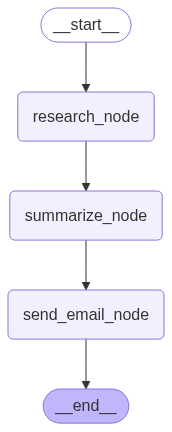

In [215]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("❌ Graph rendering failed. Make sure graphviz & mermaid dependencies are installed.")
    print(e)


# use dill == Use dill to save the agent safely

In [216]:
import dill

with open("automation_agent.pkl", "wb") as f:
    dill.dump(app, f)


# Create CSV with sample emails

In [217]:
#  Cell 8: Create CSV with sample emails
import pandas as pd

df = pd.DataFrame({
    "email": ["aryan914078@gmail.com",  "aryanpatel77462@gmail.com.com" , "arya230101047@iiitmanipur.ac.in"]
})


df.to_csv("emails.csv", index=False)


In [218]:
# df = pd.read_csv("emails.csv")

# df

In [220]:
# Test with CSV-loaded email list
import pandas as pd

emails = pd.read_csv("emails.csv")["email"].dropna().tolist()

app.invoke({
    "input": "tell me about chatgpt ai model?",
    "wiki": "",
    "arxiv": "",
    "summary": "",
    "email_list": emails
})



{'input': 'tell me about chatgpt ai model?',
 'wiki': 'Page: ChatGPT\nSummary: ChatGPT is a generative artificial intelligence chatbot developed by OpenAI and released on November 30, 2022. It uses large language models (LLMs) such as GPT-4o along with other multimodal models to generate human-like responses in text, speech, and images. It has access to features such as searching the web, using apps, and running programs. It is credited with accelerating the AI boom, an ongoing period of rapid investment in and public attention to the field of artificial intelligence (AI). Some observers have raised concern about the potential of ChatGPT and similar programs to displace human intelligence, enable plagiarism, or fuel misinformation.\nChatGPT is built on OpenAI\'s proprietary series of generative pre-trained transformer (GPT) models and is fine-tuned for conversational applications using a combination of supervised learning and reinforcement learning from human feedback. Successive user 